In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})
rc('text', usetex=True)
####reactivity parametrization of DT, D3He, DDp, DDn, TT, 3He3He reactions
## Belov et al 2019
def react(T, channel):
    if channel == 'tt':
        return 5.41*1e-14*T**(-2/3)*np.exp(-21.52/T**(1/3))
    elif channel == '3he3he':
        return 1.93*1e-12*T**(-2/3)*np.exp(-54.22/T**(1/3))
    else:
        if channel == 'dt':
            ksi =  np.array([-42.559, 33.312, -9.876,  2.501, -0.414, 0.0,   0.0])
            neta = np.array([0.0,     24.394, -16.909, 7.406, -2.148, 0.411, 0.0])
        if channel == 'd3he':
            ksi =  np.array([-60.504, 53.039, -16.233, 3.980, -0.749, 0.0, 0.004])
            neta = np.array([0.0,     43.244, -31.497, 15.707, -6.055, 1.734, -0.319])
        if channel == 'ddp':
            ksi =  np.array([-41.898, 30.017, -9.150,  2.140, -0.316, 0.0,   0.012])
            neta = np.array([0.0,     24.313, -16.995, 7.572, -2.540, 0.580, -0.068])
        if channel == 'ddn':
            ksi =  np.array([-42.145, 30.484, -9.451,  2.265, -0.346, 0.0,   0.015])
            neta = np.array([0.0,     24.459, -17.170, 7.744, -2.655, 0.630, -0.079])
        t = (np.pi/5.30)*(np.log10(T*1000) -3.65)
        s = sum(ksi[k]*np.cos(k*t)+neta[k]*np.sin(k*t) for k in range(len(ksi)))
        return np.power(10, s)
### System of particle and energy balance equations 
def F(s,t_int):    
    # Fusion reaction rates
    r_dd_p = react(s[0],'ddp') 
    r_dd_n = react(s[0],'ddn') 
    r_dt =   react(s[0],'dt')
    r_d3he = react(s[0],'d3he')    
    r_dd =   react(s[0],'ddp') + react(s[0],'ddn')
    r_tt =   react(s[0],'tt')
    r_3he3he=react(s[0],'3he3he')
    # Q values and energies for fusion reactions in MeV
    Q_ddp = 4.03; Q_ddn = 3.27; Q_d3he = 18.35;
    E_ddn = 0.82; E_adt = 3.52; E_n1 = 2.45;   E_n2 = 14.07;
    E_att = 3.7766 ; Q3he3he = 12.86; En34 = (2/3)*11.33    
    # D, T and 3He densities in cm^-3
    nd   = -r_dd   * s[1]*s[1] - r_dt  *s[1]*s[2] -r_d3he*s[1]*s[3]
    nt   = +0.5*r_dd_p * s[1]*s[1] - r_dt  *s[1]*s[2]
    n3he = +0.5*r_dd_n * s[1]*s[1] - r_d3he*s[1]*s[3]
    na   =      r_dt  *s[1]*s[2]   + r_d3he*s[1]*s[3]
    np   = +0.5*r_dd_p * s[1]*s[1] + r_d3he*s[1]*s[3]
    nn = 0.5*r_dd_n * s[1]*s[1] +r_dt  *s[1]*s[2]

    ne = nd + nt + 2*n3he + 2*na + np
    # Energy yield in keV/cm^3 for charged particles
    Ech =  (0.5*r_dd_p * s[1]*s[1]* Q_ddp + r_dt  * s[1]*s[2]* E_adt+
            0.5*r_dd_n * s[1]*s[1]* E_ddn + r_d3he* s[1]*s[3]* Q_d3he)   
    # Energy yield in MeV/cm^3 for Neutrons
    En =    (0.5*r_dd_n * s[1]*s[1]* E_n1 +  r_dt * s[1]*s[2]* E_n2) 
    ###Bremsstrahlung power radiation losses in Mev/cm^3
    Pbr = 0.334e-17*(s[0])**(0.5)*(s[1]+s[2]+4*s[3]+4*s[4]+s[5])*s[6]
    ### Temperature in keV
    ntot = s[1]+s[2]+s[3]+s[4]+s[5]+s[6]
    dntot = nd + nt + n3he + na + np + ne
    T =  (2/3)*1e+3*((Ech-Pbr)/ntot - (s[7]-s[9])*dntot/ntot**2)
    return [T, nd, nt, n3he, na, np, ne, Ech, En, Pbr,nn]

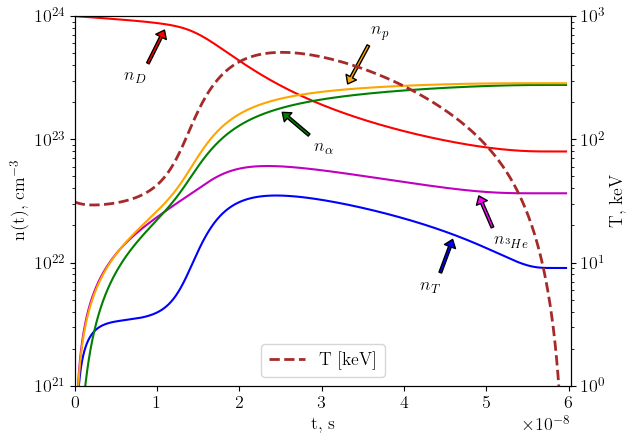

508.34243366636883 2.5175741757417573e-08
2.6905287081914873e+23


In [2]:
t_min = 0   # start-time in seconds
t_max = 5.97e-8 # finish-time in seconds
t_int = np.linspace(t_min,t_max, 100000) # number of time intervals
#[T, nd, nt, n3he, Ech, En, Ebr]  initial values
n0=[31, 10e+23,0,0, 0, 0, 10e+23, 0, 0, 0, 0] 
s = odeint(F,n0,t_int)
fig, ax1 = plt.subplots()
ax1.plot(t_int,s[:,1],'r-', linewidth=1.5)
ax1.plot(t_int,s[:,2],'b-', linewidth=1.5)
ax1.plot(t_int,s[:,3],'m-', linewidth=1.5)
ax1.plot(t_int,s[:,4],'g-', linewidth=1.5)
ax1.plot(t_int,s[:,5],'-', color='orange', linewidth=1.5)
ax1.set(xlabel='t, s',ylabel ='n(t), cm$^{-3}$',xlim=[t_min,1.01*t_max], ylim=[1e+21, 1e+24], yscale = 'log')
#ax1.legend(['$n_{D}$', '$n_{T}$', '$n_{^{3}He}$', r'$n_{\alpha}$', '$n_{p}$'])
ax2 = ax1.twinx()
ax2.plot(t_int,s[:,0],'--', color='brown', linewidth=2.0)
ax2.set(ylabel = 'T, keV', yscale ='log', ylim = [1e+0, 1e+3])

ax1.annotate('$n_{D}$', xy=(1.1e-8,8e+23),xytext=(0.6e-8, 3e+23), 
             arrowprops=dict(facecolor='red', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))
ax1.annotate('$n_{T}$', xy=(4.6e-8,1.6e+22),xytext=(4.2e-8,0.6e+22), 
             arrowprops=dict(facecolor='blue', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))

ax1.annotate(r'$n_{\alpha}$', xy=(2.5e-8,1.7e+23),xytext=(2.9e-8, 8e+22), 
             arrowprops=dict(facecolor='green', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))

ax1.annotate('$n_{^{3}He}$', xy=(4.9e-8,3.6e+22),xytext=(5.1e-8,1.4e+22), 
             arrowprops=dict(facecolor='magenta', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))

ax1.annotate('$n_{p}$', xy=(3.3e-8, 2.7e+23),xytext=(3.6e-8,7e+23), 
             arrowprops=dict(facecolor='orange', shrink=0.05, 
             width=2.0, headwidth=8.5, headlength=5.5))

#ax1.annotate('$T$', xy=(2.45e-8, 4e+21),xytext=(2.15e-8,2.3e+21), 
#             arrowprops=dict(facecolor='brown', shrink=0.05, 
#            width=2.0, headwidth=8.5, headlength=5.5))

ax2.legend(['T [keV]'], loc='lower center')
#plt.savefig('Figure2.jpg', dpi= 1000,bbox_inches='tight')
plt.show()
print(max(s[:,0]), t_int[np.argmax(s[:,0])])
print(s[np.argmax(s[:,0]),1])

In [3]:
r'''T = np.logspace(-1, 3, 25)
fig, ax = plt.subplots()
ax.set(xlabel = 'T [keV]', ylabel = r'$\langle\sigma\upsilon\rangle$$\left(T\right)$ [cm$^{3}$/s]',
       xscale = 'log', xlim=[1, 1e+3], yscale = 'log', ylim =[1e-24, 1e-14])
ax.plot(T,react(T, 'dt'), '-', color = 'blue')
ax.plot(T, react(T, 'd3he'), '->', color = 'orange')
ax.plot(T, react(T, 'ddp'), 'o-', color= 'red')
ax.plot(T, react(T, 'ddn'), '--', color='green')
ax.plot(T,react(T, '3he3he'), ':', color='magenta')
ax.plot(T,react(T, 'tt'), '-.', color='purple')
ax.legend([r'D+T', r'D+$^{3}$He', 
           r'D+D$\rightarrow$p+T', r'D+D$\rightarrow$n+$^{3}$He',
           r'$^{3}$He+$^{3}$He',
           r'T+T'])
plt.savefig('Figure2.jpg', dpi= 1000,bbox_inches='tight')
'''
print(t_int[np.argmax(s[:,0])], max(s[:,0]))

2.5175741757417573e-08 508.34243366636883


3.374372695887832e+31
5.373053730537305e-08


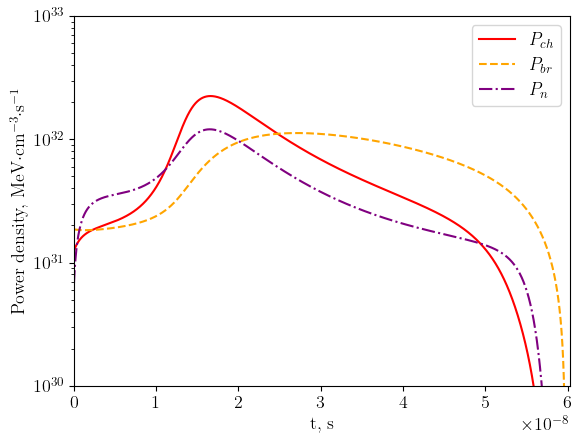

In [4]:
Pch = np.zeros(len(t_int)-1)
Pbr = np.zeros(len(t_int)-1)
Pn = np.zeros(len(t_int)-1)
t_int2 = np.zeros(len(t_int)-1)
t_int3 = np.zeros(len(t_int)-100)
for i in range(len(t_int)-1):
    Pch[i]=(s[i+1,7]-s[i,7])/(t_int[i+1]-t_int[i])
    Pbr[i]=(s[i+1,9]-s[i,9])/(t_int[i+1]-t_int[i])
    Pn[i]=(s[i+1,8]-s[i,8])/(t_int[i+1]-t_int[i])
    t_int2[i] = t_int[i]

fig, ax = plt.subplots()
ax.set(xlabel = 't, s', ylabel = 'Power density, MeV$\cdot$cm$^{-3}$$\cdot$s$^{-1}$', 
       yscale = 'log', ylim=[1e+30, 1e+33], xlim=[t_min, 1.01*t_max])
ax.plot(t_int2, Pch, '-', color = 'red', linewidth = 1.5)
ax.plot(t_int2, Pbr, '--', color = 'orange', linewidth = 1.5)
ax.plot(t_int2, Pn, '-.', color = 'purple', linewidth = 1.5)
ax.legend(['$P_{ch}$', '$P_{br}$', '$P_{n}$'])
#ax.annotate('$P_{ch}$', xy=(1.4e-8, 2.4e+31),xytext=(1.2e-8,6e+30), 
#             arrowprops=dict(facecolor='red', shrink=0.05, 
#             width=2.0, headwidth=8.5, headlength=5.5))

#ax.annotate('$P_{n}$', xy=(0.5e-8, 3e+32),xytext=(0.7e-8,7e+32), 
#             arrowprops=dict(facecolor='purple', shrink=0.05, 
#             width=2.0, headwidth=8.5, headlength=5.5))

#ax.annotate('$P_{br}$', xy=(0.3e-8, 7e+31),xytext=(0.4e-8,2e+31), 
#             arrowprops=dict(facecolor='orange', shrink=0.05, 
#             width=2.0, headwidth=8.5, headlength=5.5))

#print(t_int[np.argmax(Pch)], max(Pch))
#print(t_int[np.argmax(Pbr)], max(Pbr))
#print(t_int[np.argmax(Pn)], max(Pn))

print(Pbr[90000])
print(t_int2[90000])
#plt.savefig('Figure3.jpg', dpi= 1000,bbox_inches='tight')


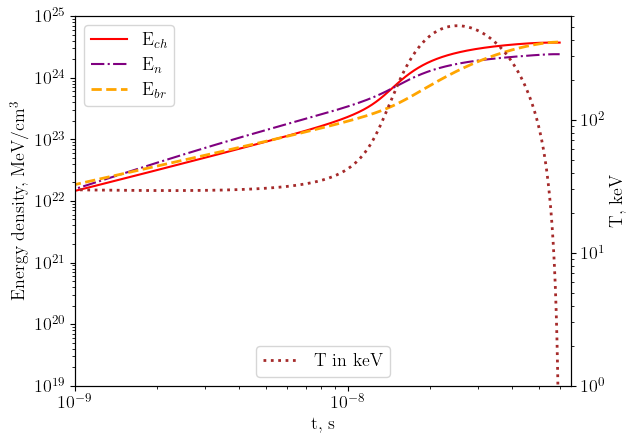

3.7996089607146093e+24
5.97e-08


In [5]:
fig, ax = plt.subplots()
ax.set(xlim = [1e-9, 1.1*t_max],ylim=[1e+19, 1e+25], 
      xlabel = 't, s', ylabel = 'Energy density, MeV/cm$^{3}$', yscale = 'log', xscale = 'log')
ax.plot(t_int, s[:,7], '-', color = 'red', linewidth = 1.5)
ax.plot(t_int, s[:,8], '-.', color = 'purple')
ax.plot(t_int, s[:,9], '--', color = 'orange', linewidth= 2.0)
ax.legend(['E$_{ch}$', 'E$_{n}$', 'E$_{br}$'])
ax2 = ax.twinx()
ax2.plot(t_int,s[:,0],':', color='brown', linewidth=2.0)
ax2.set(ylabel = 'T, keV', yscale ='log', ylim = [1e+0, 6e+2])
ax2.legend(['T in keV'], loc = 'lower center')
#plt.savefig('Figure 4.jpg', dpi= 1000,bbox_inches='tight')
plt.show()
print(s[99999,9])
print(t_int[99999])

3.539528995289953e-08 0.6128777432891617


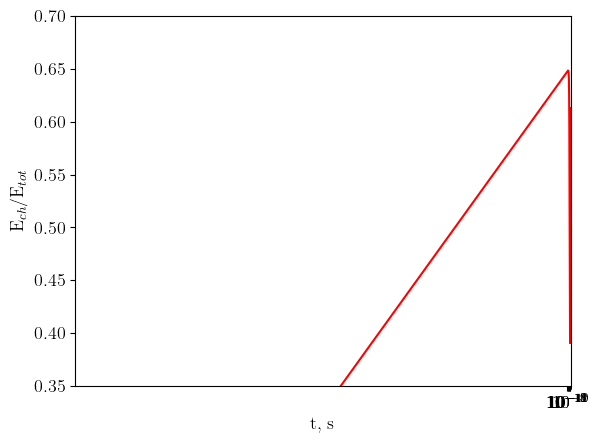

In [6]:
fig, ax = plt.subplots()
t_int3 = np.zeros(len(t_int))
ratio = np.zeros(len(t_int))
for i in range(1, len(t_int)):
    ratio[i] = s[i,7]/(s[i,7]+s[i,8])
    t_int3[i] = t_int[i]
ax.plot(t_int3, ratio, color = 'red', linewidth = 1.5)
ax.set(xlim = [t_min, 1.01*t_max], ylim=[0.35, 0.7], ylabel = 'E$_{ch}$/E$_{tot}$', xlabel = 't, s',
      xscale = 'log')
#plt.savefig('Figure 5.jpg', dpi= 1000,bbox_inches='tight')
print(t_int[np.argmax(ratio[10000:99999])], max(ratio[10000:99999]))

1.6594974949749495e-08 2.246235189262793e+32
3.361834e-10 6.694978135846081e+32
2.9805330126821454


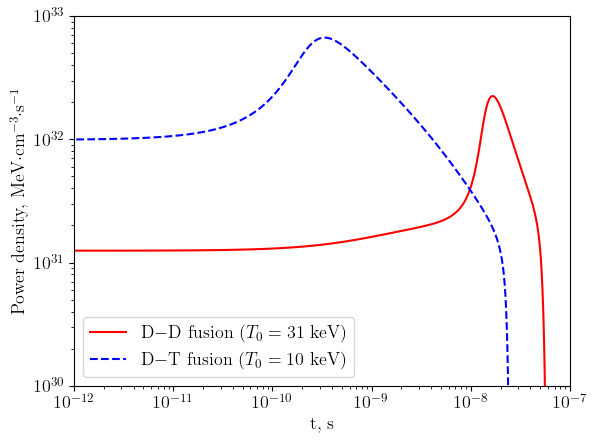

In [8]:
Pch = np.zeros(len(t_int)-1)
Pbr = np.zeros(len(t_int)-1)
Pn = np.zeros(len(t_int)-1)
t_int2 = np.zeros(len(t_int)-1)
t_int3 = np.zeros(len(t_int)-100)
for i in range(len(t_int)-1):
    Pch[i]=(s[i+1,7]-s[i,7])/(t_int[i+1]-t_int[i])
    Pbr[i]=(s[i+1,9]-s[i,9])/(t_int[i+1]-t_int[i])
    Pn[i]=(s[i+1,8]-s[i,8])/(t_int[i+1]-t_int[i])
    t_int2[i] = t_int[i]
time, DT = np.genfromtxt('Pbr.txt', unpack=True)
fig, ax = plt.subplots()
ax.set(xlabel = 't, s', ylabel = 'Power density, MeV$\cdot$cm$^{-3}$$\cdot$s$^{-1}$', 
       yscale = 'log', ylim=[1e+30, 1e+33], xlim=[1e-12, 1e-7], xscale = 'log')
ax.plot(t_int2, Pch, '-', color = 'red', linewidth = 1.5)
ax.plot(time, DT, '--', color = 'blue', linewidth = 1.5)
ax.legend(['D$-$D fusion ($T_{0}=31$ keV)', 'D$-$T fusion ($T_{0}=10$ keV)'], loc = 'lower left')

print(t_int[np.argmax(Pch)], max(Pch))
print(time[np.argmax(DT)], max(DT))
print(max(DT)/max(Pch))
#print(''+str(round(max(DT)/max(Pch))))
#print(t_int[np.argmax(Pbr)], max(Pbr))
#plt.savefig('Figure 6.jpg', dpi= 1000,bbox_inches='tight')